# **CHARGEMENT ET PRETRAITEMENT DES AUDIO**

In [1]:
!pip install noisereduce

In [2]:
import librosa
import noisereduce as nr
import numpy as np
import os
import IPython.display as ipd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io.wavfile import write
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

*Charger tous les audio*

In [3]:
def charger_dossier_audio(chemin_dossier, chemin_augmented):

    fichiers_audio = os.listdir(chemin_dossier)
    fichiers_audio_aug = os.listdir(chemin_augmented)

    liste_audio = []
    liste_sr = []
    fichiers = []

    for fichier in fichiers_audio:
      # Ignore hidden files
        if fichier.startswith('.'):
            continue
        chemin_fichier = os.path.join(chemin_dossier, fichier)
        audio, sr = librosa.load(chemin_fichier, sr=None) # sr=None pour conserver le taux d'échantillonnage d'origine
        liste_audio.append(audio)
        liste_sr.append(sr)
        fichiers.append(fichier)

    for fichier in fichiers_audio_aug:
      # Ignore hidden files
        if fichier.startswith('.'):
            continue
        chemin_fichier = os.path.join(chemin_augmented, fichier)
        audio, sr = librosa.load(chemin_fichier, sr=None) # sr=None pour conserver le taux d'échantillonnage d'origine
        liste_audio.append(audio)
        liste_sr.append(sr)
        fichiers.append(fichier)


    return liste_audio, liste_sr, fichiers

In [4]:
# Fonction pour afficher l'onde sonore
def afficher_onde_sonore(audio, sr, labels):
  plt.figure(figsize=(18, 9))
  for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(audio[i])
    plt.title(f"Chiffre {labels[i]}")
    plt.xlabel("Temps")
    plt.ylabel("Amplitude")
  plt.show()

In [5]:
chemin_dossier = ("/content/drive/My Drive/dataset_aa/dataset")
chemin_augmented = ("/content/drive/My Drive/dataset_aa/Augmented")

labels = []

# Charger tous les audios
audio, sr, fichiers = charger_dossier_audio(chemin_dossier, chemin_dossier)

# recupérér et melanger les fichier audio
random.shuffle(fichiers)

# Recuperer les labels
for fichier in fichiers:
  label = int(fichier[0])
  labels.append(label)

*PRETRAITEMENT DES AUDIOS: normalisation et suppression des bruits*

La normalisation des données présente plusieurs avantages: l'uniformité des niveaux sonores, l'amélioration de la qualité des caractéristiques, la stabilité du modèle

La suppression des bruits se fera avec la bibliothèque noicereduce pour plusieurs raisons:
- Librosa ne propose pas de fonctionnalités avancées de réduction de bruit par défaut.
- Librosa est plus orientée vers l'analyse et la transformation que vers le prétraitement audio comme la réduction de bruit.
- Noicereduce est spécialisée dans la réduction de bruit, offrant des algorithmes performants pour cette tâche.
- Elle propose des fonctionnalités simples et efficaces pour le prétraitement audio

In [11]:
def supprimer_bruit(liste_audio, liste_sr):
    clean_audio = []

    for audio, sr in zip(liste_audio, liste_sr):
        # Extraction du profil de bruit
        noise_profile = audio[:sr]

        # Appliquer la réduction de bruit
        audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)

        # Retirer les moments de silence en début et à la fin de l'audio
        audio_trim, _ = librosa.effects.trim(audio_denoised, top_db=20)

        #Normaliser l'audio
        audio_norm = librosa.util.normalize(audio_trim)

        clean_audio.append(audio_norm)
    return clean_audio

In [12]:
clean_audio =  supprimer_bruit(audio,sr)

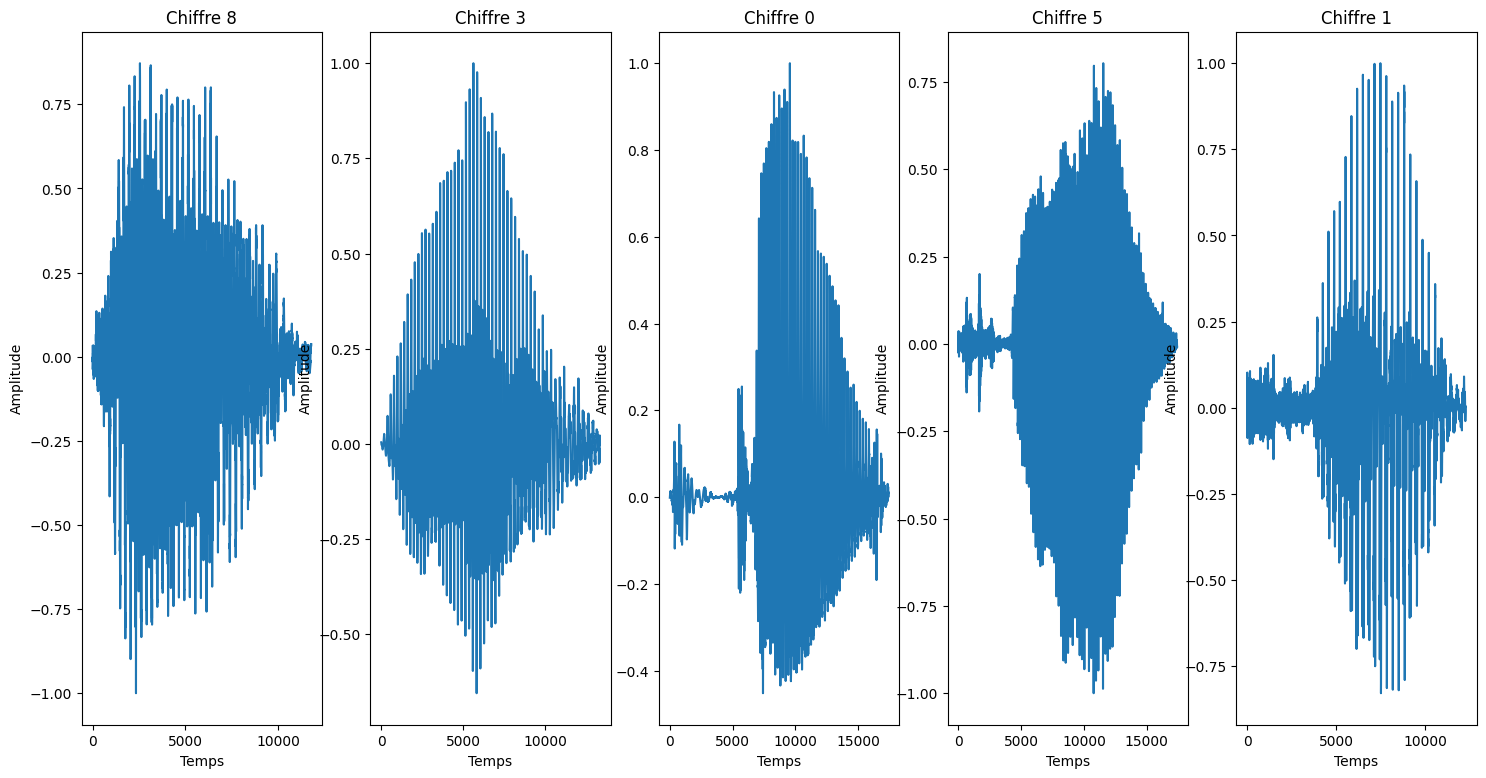

In [13]:
afficher_onde_sonore(clean_audio, sr, labels)

#**Extraire les fonctionnalités d'un fichier audio | MFCC |**
Les MFCC (Coefficients Cepstraux Mel-Fréquence) sont des coefficients qui représentent les caractéristiques spectrales du signal audio.. Il s'agit d'une technique d'extraction de caractéristiques largement utilisée dans le domaine du traitement du signal audio, en particulier pour des tâches telles que l'analyse, la reconnaissance et la classification de la parole et de la musique. Les MFCC sont dérivés des caractéristiques spectrales d’un signal audio et sont conçus pour imiter la perception du son par le système auditif humain.

In [14]:
def extraire_mfccs(clean_audio, liste_sr, n_mfcc=40):
    mfcc_audios = []

    for audio, sr in zip(clean_audio, liste_sr):
        # Vérifier si audio est un tableau numpy
        if isinstance(audio, np.ndarray):
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)  # n_mfcc est le nombre de coefficients MFCC à extraire

            # Calculer les moyennes des MFCCs pour obtenir un vecteur de taille fixe
            mfccs = np.mean(mfccs, axis=1)
            mfcc_audios.append(mfccs)
        else:
            raise ValueError("Chaque segment audio doit être un tableau numpy")

    return mfcc_audios



In [15]:
mfcc_audios = extraire_mfccs(clean_audio, sr)

In [16]:
mfcc_audios[0].shape

(40,)

# **OBSERVATIONS ET LABELS**

In [17]:
from sklearn.preprocessing import MinMaxScaler # import MinMaxScaler

# Convertir les listes en tableaux numpy
X = np.array(mfcc_audios)
y = np.array(labels)

# Normalisation minmax
scaler = MinMaxScaler(feature_range = (-1,1))
X = scaler.fit_transform(X)
print(X.shape)
print(y.shape)

(3522, 40)
(3522,)


Division des données en Train-Valid-Test

In [18]:
# Diviser les données en ensembles d'entraînement et de test

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.36, random_state=42)

#Diviser les données de test en ensemble de test et de validation
X_valid, X_test, y_valid, y_test= train_test_split(X_tmp, y_tmp, test_size=0.2/0.36, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(2254, 40)
(563, 40)
(705, 40)


**One hot Encoding**

In [19]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(2254, 10)
(563, 10)
(705, 10)


In [20]:
for i in range(3):
    print(y_train[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# **Conception du modèle**

In [38]:
# Instantiation et construction du modèle.

model = Sequential([
    Dense(200, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.1),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

# Display the model summary.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               8200      
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                2010      
                                                                 
Total params: 50410 (196.91 KB)
Trainable params: 50410 (196.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### COMPILATION DU MODELE

In [40]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### TRAIN THE MODEL

In [45]:
from gc import callbacks
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

training_results = model.fit(X_train,
                             y_train,
                             epochs=80,
                             batch_size=80,
                             validation_data=(X_valid, y_valid),
                             callbacks = early_stopping);

Epoch 1/80
29/29 [==============================] - 0s 14ms/step - loss: 2.2745 - accuracy: 0.1420 - val_loss: 2.3123 - val_accuracy: 0.0799
Epoch 2/80
29/29 [==============================] - 0s 6ms/step - loss: 2.2679 - accuracy: 0.1477 - val_loss: 2.3086 - val_accuracy: 0.1137
Epoch 3/80
29/29 [==============================] - 0s 7ms/step - loss: 2.2580 - accuracy: 0.1642 - val_loss: 2.3085 - val_accuracy: 0.1332
Epoch 4/80
29/29 [==============================] - 0s 6ms/step - loss: 2.2457 - accuracy: 0.1744 - val_loss: 2.3156 - val_accuracy: 0.1083
Epoch 5/80
29/29 [==============================] - 0s 8ms/step - loss: 2.2319 - accuracy: 0.1868 - val_loss: 2.3278 - val_accuracy: 0.1137
Epoch 6/80
29/29 [==============================] - 0s 8ms/step - loss: 2.2221 - accuracy: 0.1948 - val_loss: 2.3318 - val_accuracy: 0.1030
Epoch 7/80
29/29 [==============================] - 0s 6ms/step - loss: 2.2060 - accuracy: 0.2001 - val_loss: 2.3419 - val_accuracy: 0.1297
Epoch 8/80
29/29 [=

Define a utility functio to plot the result

In [46]:
#Visualisation des résultats de l'entrainement
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 80])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

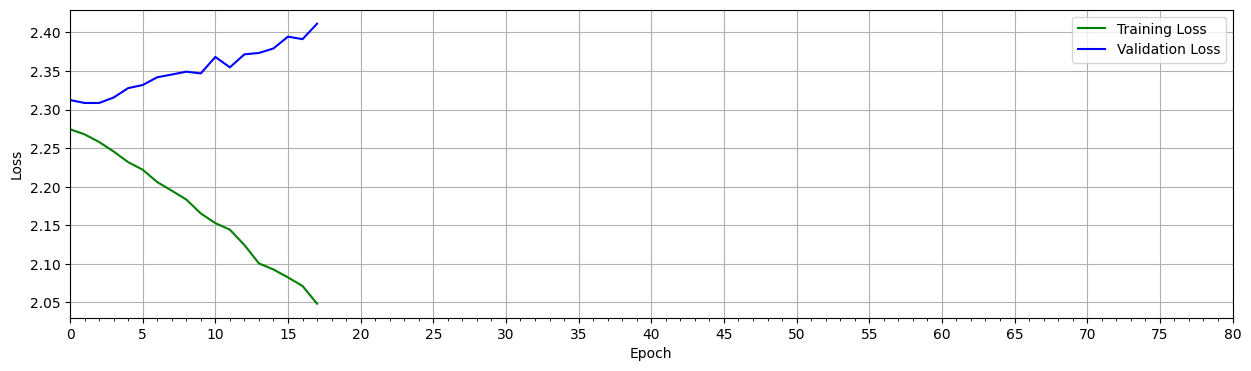

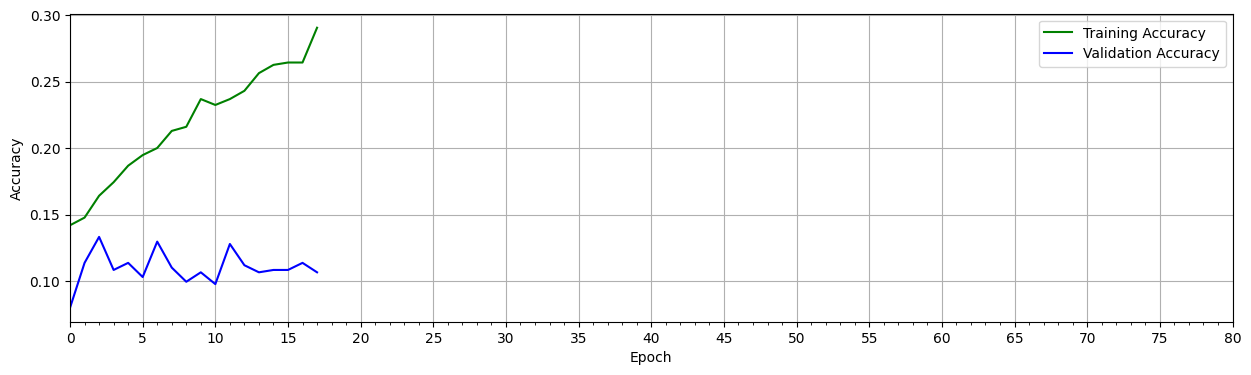

In [47]:
#Visualisation de la Loss et de l'Accuracy
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [48]:
train_acc[-1], valid_acc[-1]

(0.2905944883823395, 0.10657193511724472)

Making predictions on sample Test Images

In [33]:
predictions = model.predict(X_test)
index = 0
print('Ground truth for test digit: ',y_test[index])
print('\n');
print('Predictions for each class:\n')
for i in range(10):
    print('digit:', i, ' probability: ', predictions[index][i])

23/23 [==============================] - 0s 2ms/step
Ground truth for test digit:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Predictions for each class:

digit: 0  probability:  0.09800149
digit: 1  probability:  0.08951925
digit: 2  probability:  0.0917859
digit: 3  probability:  0.09885997
digit: 4  probability:  0.102370836
digit: 5  probability:  0.10723166
digit: 6  probability:  0.10288619
digit: 7  probability:  0.10169173
digit: 8  probability:  0.10812953
digit: 9  probability:  0.099523365


In [34]:
# generation de la prediction pour les données test
predictions = model.predict(X_test)

# pour chaque image des données test on selectionne la classe avec la plus grande probabilité
predicted_labels = [np.argmax(i) for i in predictions]

23/23 [==============================] - 0s 3ms/step


In [35]:
for i in range(10):
    print (f"Valeur vraie : {y_test[i]} ---- Valeur prédite : {predicted_labels[i]}")

Valeur vraie : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] ---- Valeur prédite : 8
Valeur vraie : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] ---- Valeur prédite : 5
Valeur vraie : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] ---- Valeur prédite : 6
Valeur vraie : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] ---- Valeur prédite : 5
Valeur vraie : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] ---- Valeur prédite : 8
Valeur vraie : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] ---- Valeur prédite : 5
Valeur vraie : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ---- Valeur prédite : 5
Valeur vraie : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] ---- Valeur prédite : 5
Valeur vraie : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] ---- Valeur prédite : 6
Valeur vraie : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] ---- Valeur prédite : 6


##### Csnfusion Matrix

In [36]:
# Generate predictions for the test dataset.
predictions = model.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

23/23 [==============================] - 0s 2ms/step


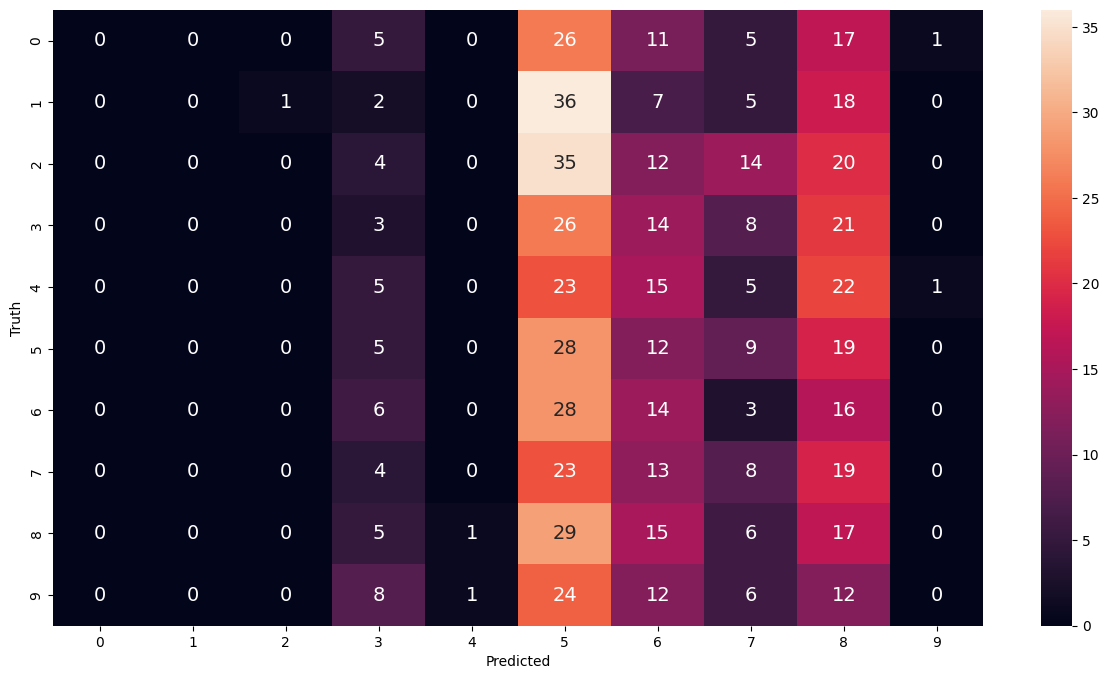

In [37]:
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()